# NLP (Natural Language Processing) и Обучение с учителем (Supervised Learning)

## Классификация текстовых данных

## Данные

Источник: https://www.kaggle.com/crowdflower/twitter-airline-sentiment?select=Tweets.csv

Эти данные изначально были получены из библиотеки "Crowdflower's Data for Everyone".

#### Цель: создать алгоритм машинного обучения, который для нового твита будет определять его эмоциональную окраску - позитивный, нейтральный или негативный твит. Такой алгоритм можно будет применять для автоматического чтения твитов и поиска тех твитов, на которые следует обратить внимание службе поддержки клиентов той или иной авиакомпании.

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [6]:
df = pd.read_csv('../DATA/airline_tweets.csv')
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


## Визуализация данных

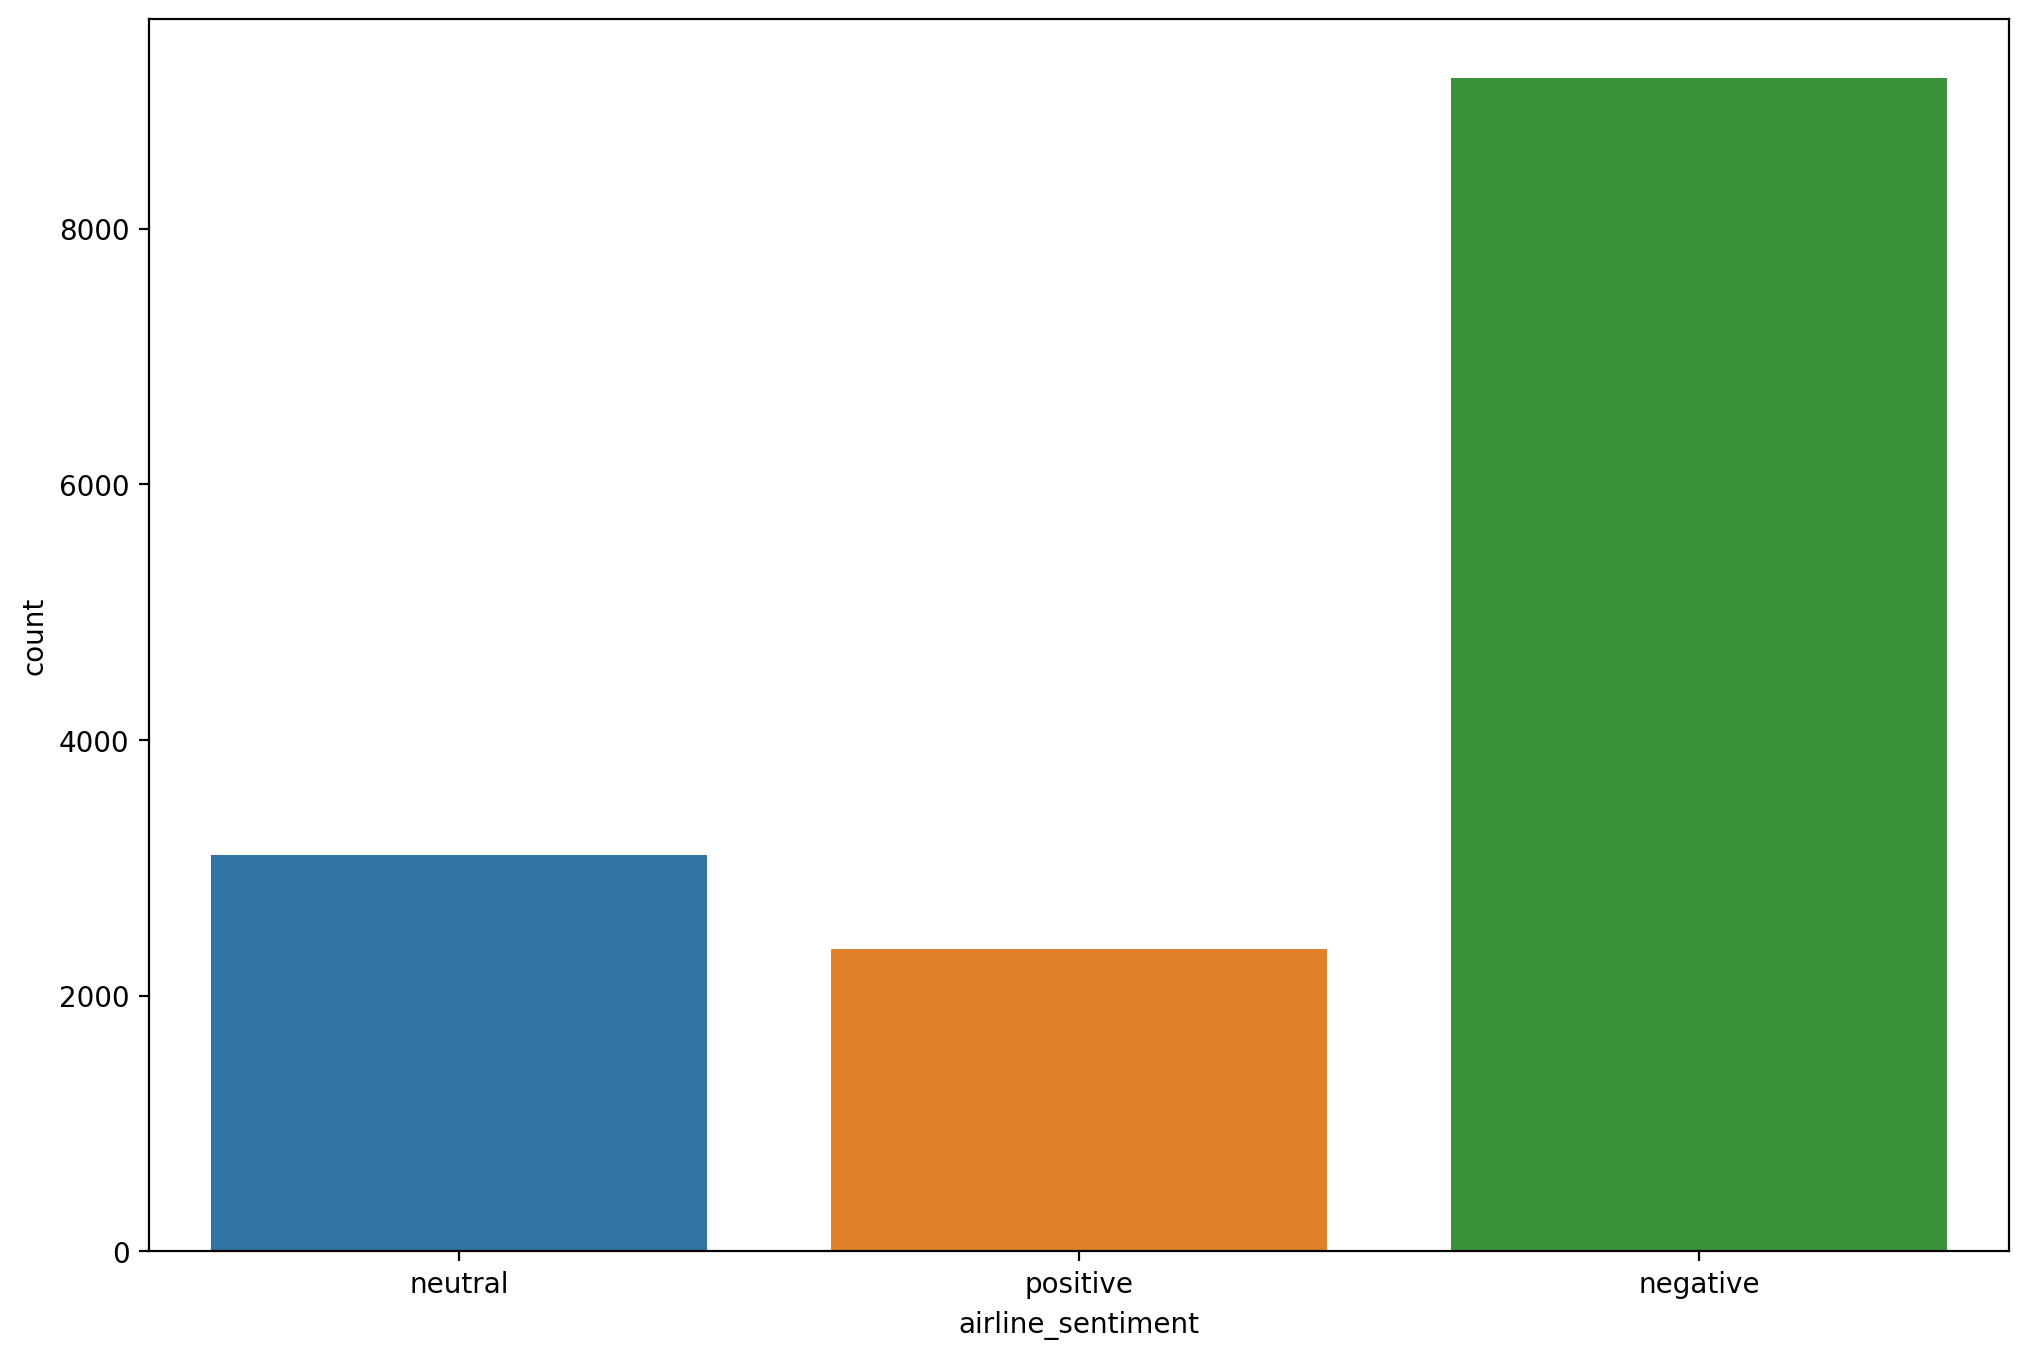

In [10]:
plt.figure(figsize=(12, 8), dpi=200)
sns.countplot(data=df, x='airline_sentiment', hue='airline_sentiment')
plt.show()

Видим, что большинство твитов является негативными. В поставленной задаче хотелось бы научиться отделять негативные твиты от всех остальных. Т.е. вполне можно решать задачу с двумя классами - негативные твиты и все остальные, так как разница между положительными и нейтральными твитами не так важна.

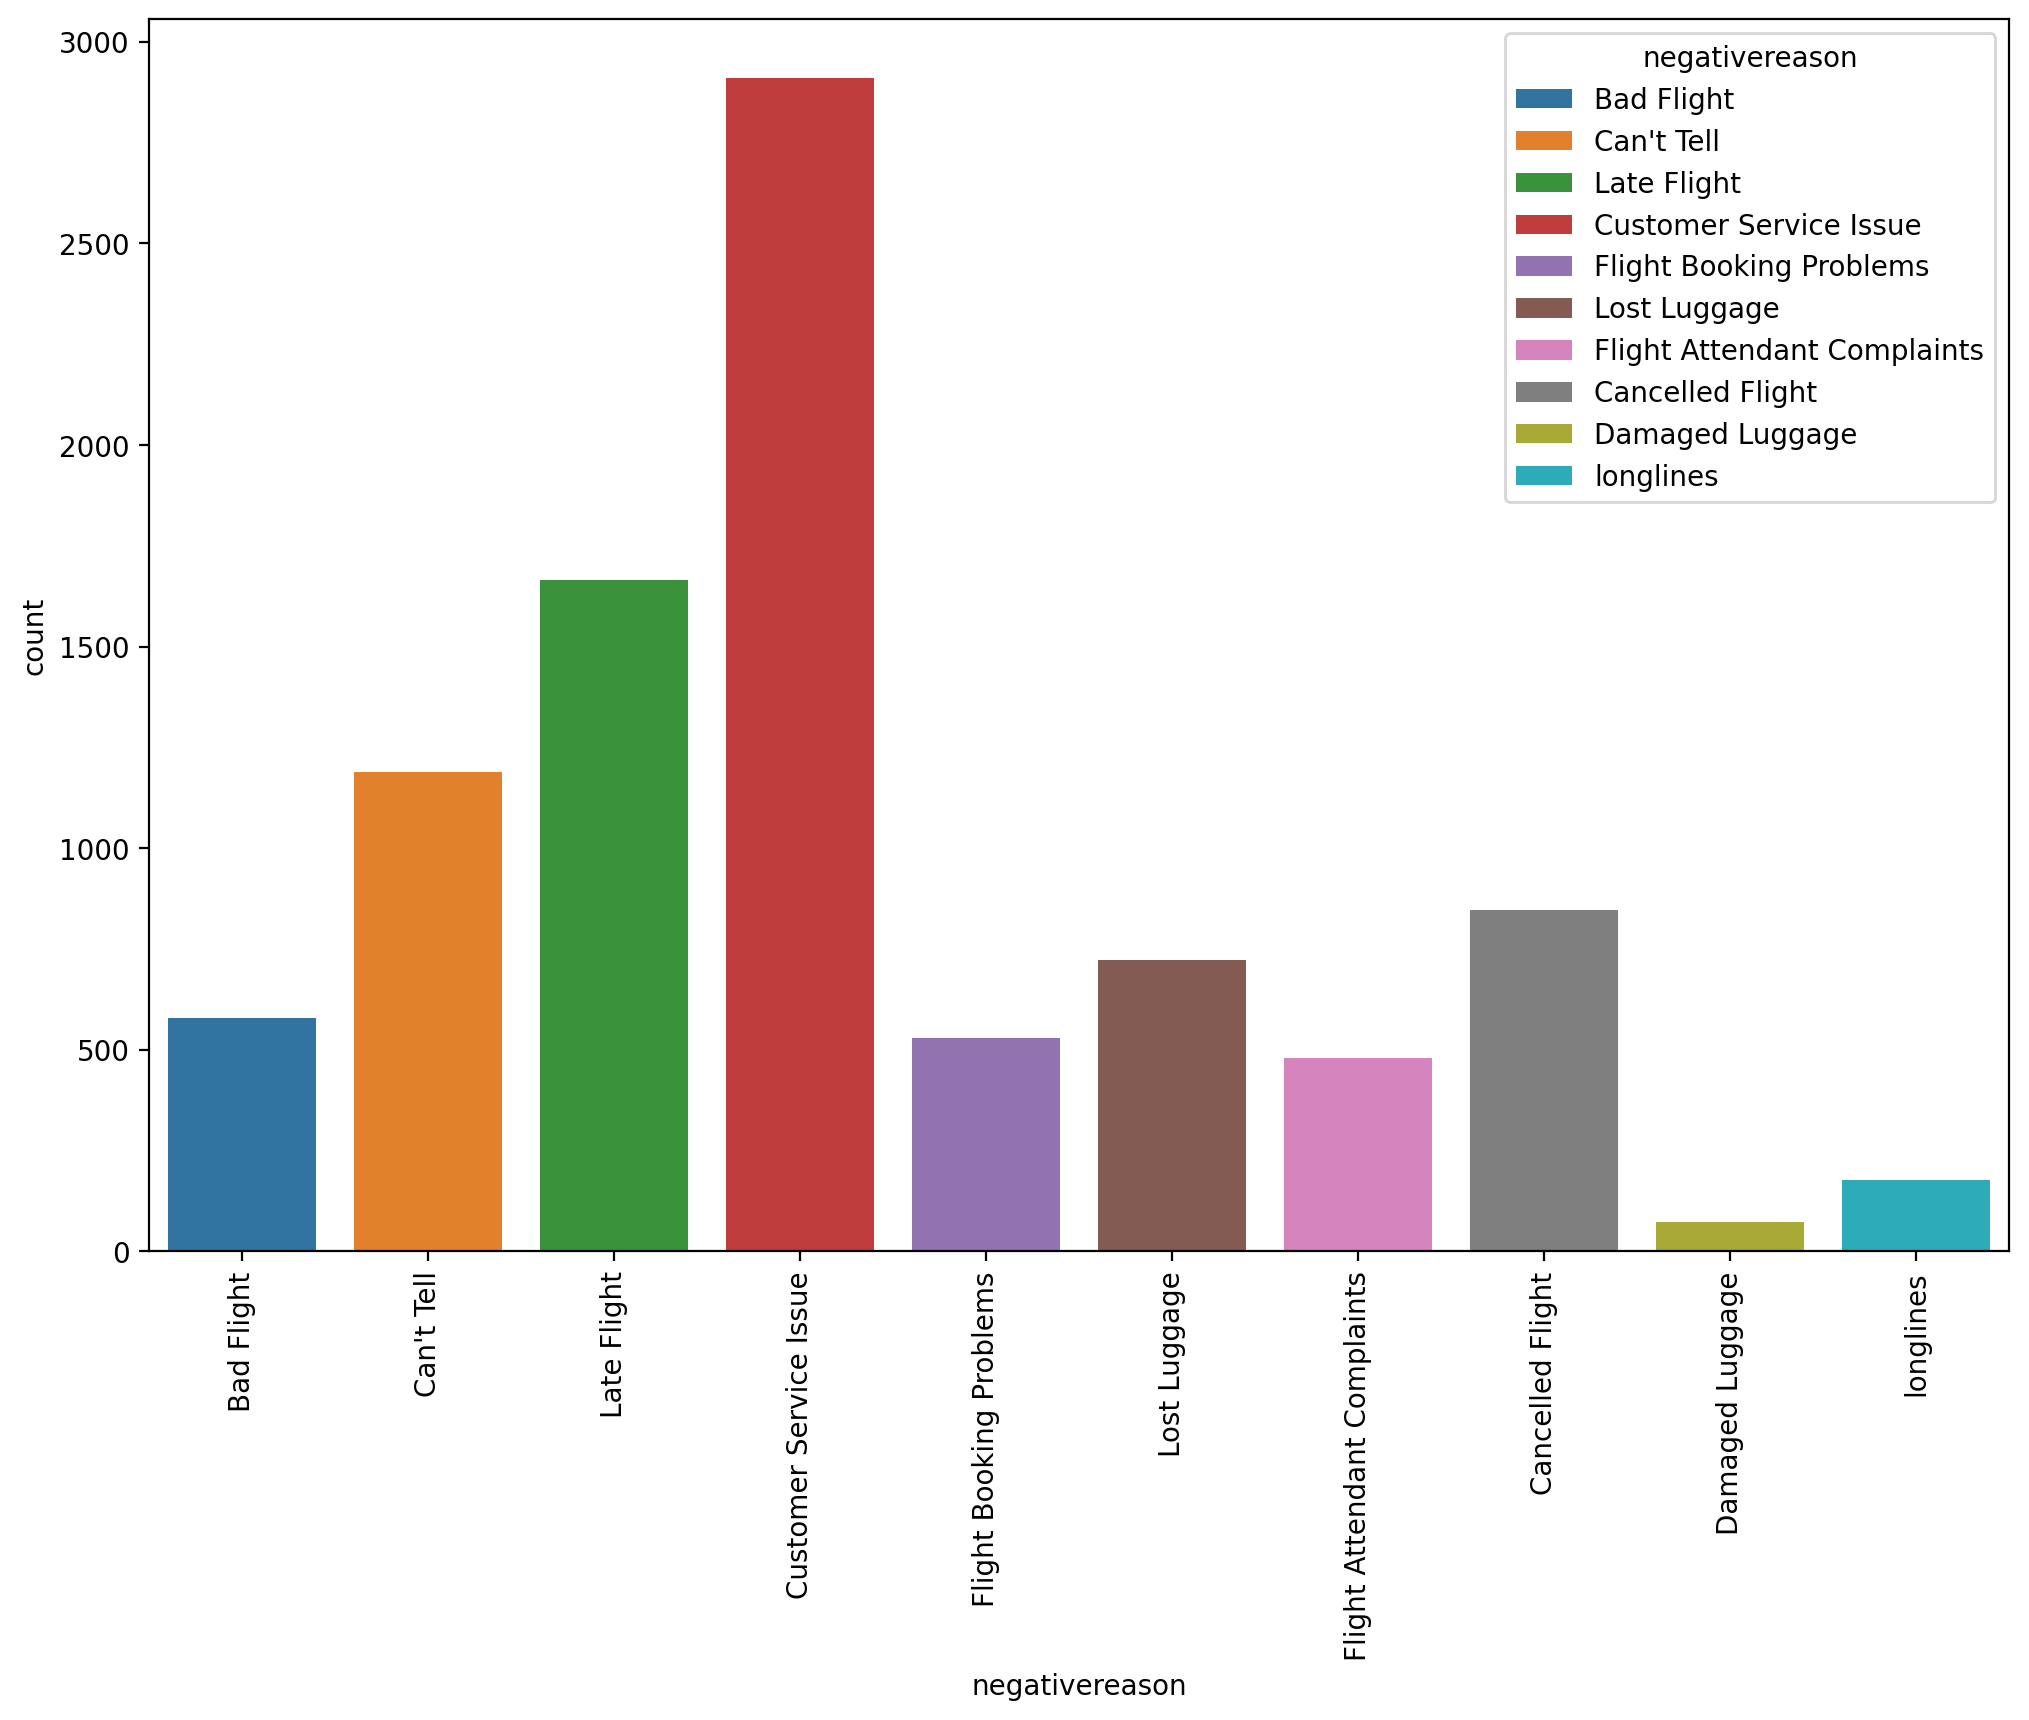

In [13]:
plt.figure(figsize=(12, 8), dpi=200)
sns.countplot(data=df, x='negativereason', hue='negativereason')
plt.xticks(rotation=90)
plt.show()

Видим, что самая частая причина негативных твитов - это *Customer Service Issue*, вторая - *Late Flight*. 

**Важно - в этих данных, много различных авиакомпаний, имеет смысл посмотреть каждую в отдельности.**

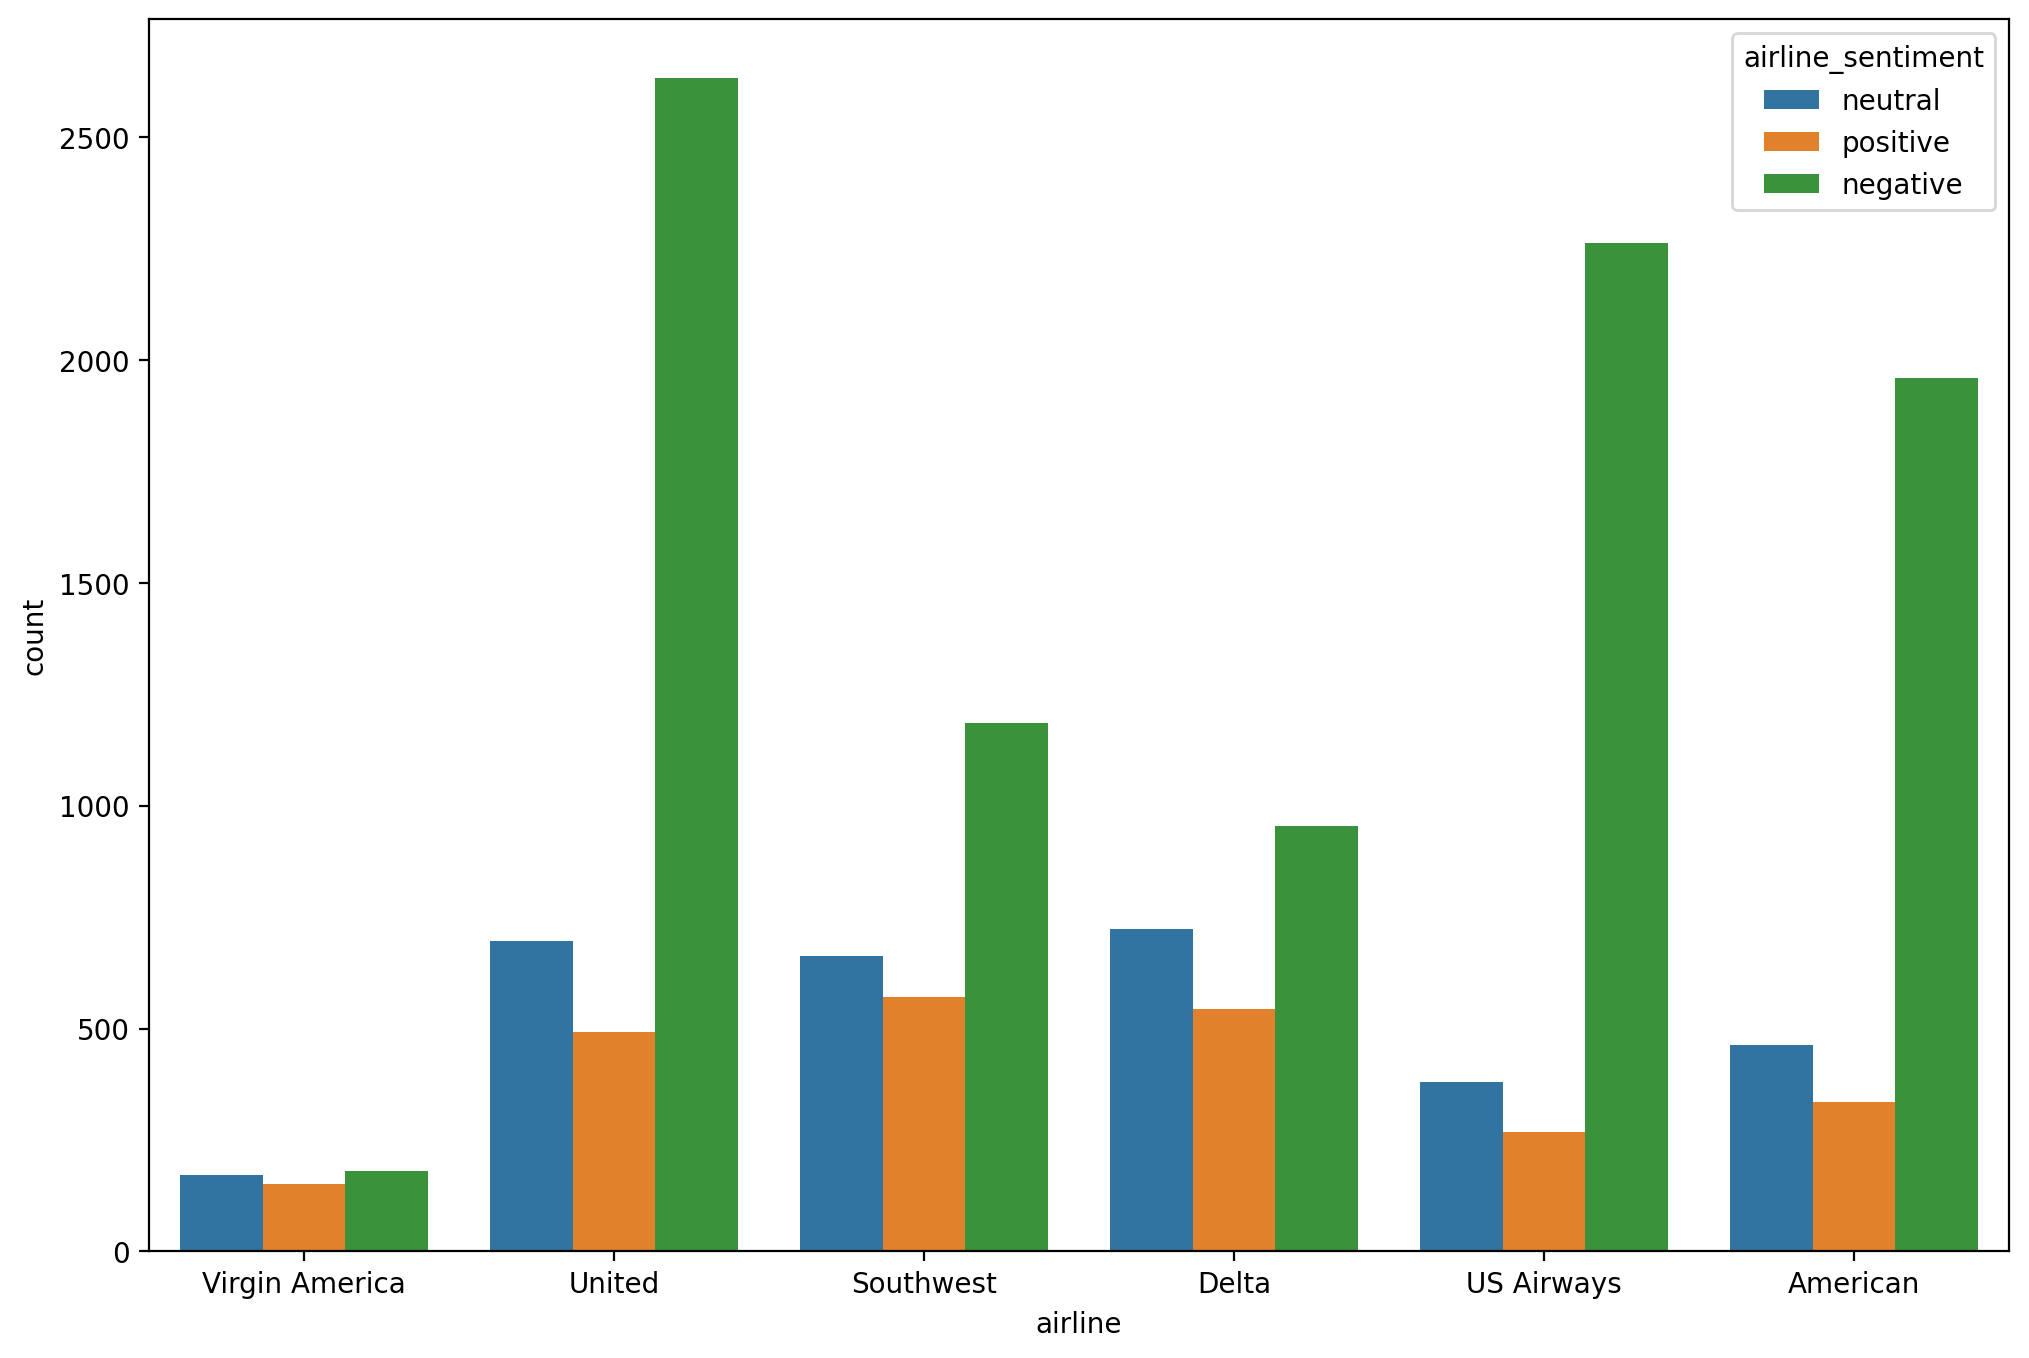

In [105]:
plt.figure(figsize=(12, 8), dpi=200)
sns.countplot(data=df, x='airline', hue='airline_sentiment')
plt.show()

## Признаки и целевая переменная

In [23]:
# В качестве признака возьмём текст твита
data = df[['airline_sentiment', 'text']]

In [25]:
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [27]:
X = data['text']
y = data['airline_sentiment']

## Разбиение на обучающий и тестовый наборы данных - Train Test Split

**Важно: этот шаг выполняется перед векторизацией текста. Это нужно чтобы избежать утечки информации из тестовых данных в обучающие данные при использовании метода `.fit()`**

In [30]:
from sklearn.model_selection import train_test_split

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

## Векторизация текста

In [35]:
from sklearn.feature_extraction.text import TfidfVectorizer

В данном случае очень важно учитывать то, как часто встречаются те или иные слова во всём наборе документов, за это как раз отвечает множитель IDF.

В данном примере это документы на тему авиакомпаний, поэтому некоторые слова могут повторяться во многих документах.

In [38]:
tfidf = TfidfVectorizer(stop_words='english')

Это похоже на масштабирование данных - мы запускаем метод `.fit()` только для обучающих данных, а затем запускаем `.transform()` как для обучающих, так и для тестовых данных.

In [40]:
tfidf.fit(X_train)

TfidfVectorizer(stop_words='english')

Здесь X_train - это текстовые данные

In [46]:
X_train_tfidf = tfidf.transform(X_train)

In [48]:
X_test_tfidf = tfidf.transform(X_test)

In [50]:
X_train_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 107073 stored elements and shape (11712, 12971)>

In [53]:
X_test_tfidf

<Compressed Sparse Row sparse matrix of dtype 'float64'
	with 24951 stored elements and shape (2928, 12971)>

Получили разреженную матрицу. Её размеры слишком большие, поэтому метод `.todense()` лучше не запускать.

В рассмотренном примере после деления на train/test выборки и применения TfidfVectorizer() получилось одинаковое количество столбцов(слов) 12971 в двух выборках. И это означает, что слова (столбцы) были взяты только из train данных, но если какое то одно слово или несколько есть только в test, то эти слова не будут включены в модель для анализа. То есть словарь слов формируется только из train выборки и далее transform для новых данных производит расчеты исходя из этого словаря слов.

Дело в том, что тестовые данные - это эмуляция совершенно новых данных, к которым модель будет применяться в будущем. Поскольку совершенно новые данные по определению нам неизвестны, то они не могут участвовать в обучении модели. По аналогии, и тестовые данные тоже не должны участвовать в обучении модели.

При этом количество таких слов, которые есть в test и нету в train, всё-таки должно быть небольшим. Если таких слов становится много - то это повод заново сформировать обучающий набор данных, включая эти слова, и заново обучить модель. 

# Сравнение моделей - Naive Bayes, LogisticRegression, LinearSVC

In [63]:
from sklearn.naive_bayes import MultinomialNB
nb=MultinomialNB()
nb.fit(X_train_tfidf, y_train)

MultinomialNB()

In [65]:
from sklearn.linear_model import LogisticRegression
log_model = LogisticRegression()
log_model.fit(X_train_tfidf, y_train)

LogisticRegression()

In [67]:
from sklearn.svm import SVC, LinearSVC

In [71]:
rbf_svc = SVC()
rbf_svc.fit(X_train_tfidf, y_train)

SVC()

In [73]:
linear_svc = LinearSVC()
linear_svc.fit(X_train_tfidf, y_train)

LinearSVC()

## Оценка работы модели

In [78]:
from sklearn.metrics import ConfusionMatrixDisplay, classification_report

In [80]:
def report(model):
    """
    Вспомогательная функция для оценки полученных моделей.
    """
    preds = model.predict(X_test_tfidf)
    print(classification_report(y_test, preds))
    ConfusionMatrixDisplay.from_estimator(model, X_test_tfidf, y_test)

              precision    recall  f1-score   support

    negative       0.66      0.99      0.79      1817
     neutral       0.79      0.15      0.26       628
    positive       0.89      0.14      0.24       483

    accuracy                           0.67      2928
   macro avg       0.78      0.43      0.43      2928
weighted avg       0.73      0.67      0.59      2928



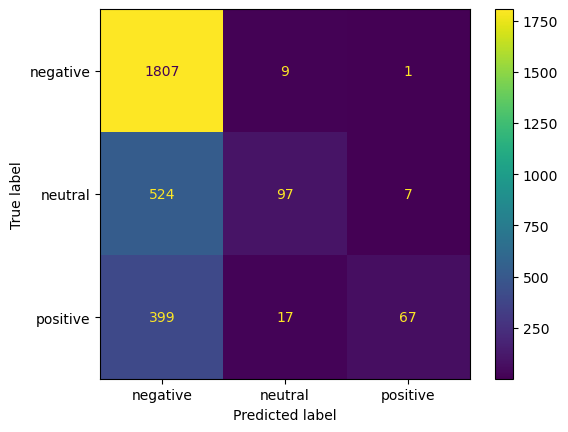

In [82]:
report(nb)

В принципе модель работает весьма неплохо. Если посмотреть на матрицу ошибок - то наша модель непраильно классифицировала 10 твитов(9+1), которые на самом деле были негативными, но модель решила иначе.

Стоит также отметить, что модель говорит, что твиты негативные для достаточно большого количества положительных и нейтральных твитов, т.е. модель в целом отмечает очень много твитов как негативные. Можно даже сказать, что за счёт этого, модель правильно классифицирует многие негативные твиты, по сути она их просто угадывает, но при этом она часто ошибается для классов *positive* и *neutral* - значение метрик **recall** и **f1-score** достаточно низкие.

              precision    recall  f1-score   support

    negative       0.80      0.93      0.86      1817
     neutral       0.63      0.47      0.54       628
    positive       0.81      0.58      0.68       483

    accuracy                           0.77      2928
   macro avg       0.75      0.66      0.69      2928
weighted avg       0.77      0.77      0.76      2928



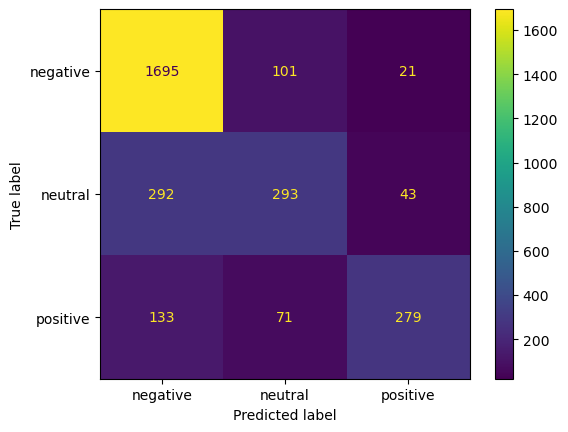

In [90]:
report(log_model)

Видим, что **f1-score** выглядит значительно лучше.

Если посмотреть на матрицу ошибок - здесь больше отрицательных твитов, которые модель не смогла определить правильно(в сумме это 122 твита), но зато, эта модель может лучше разбивать данные на три класса.

              precision    recall  f1-score   support

    negative       0.78      0.95      0.86      1817
     neutral       0.67      0.41      0.51       628
    positive       0.81      0.56      0.66       483

    accuracy                           0.77      2928
   macro avg       0.75      0.64      0.67      2928
weighted avg       0.76      0.77      0.75      2928



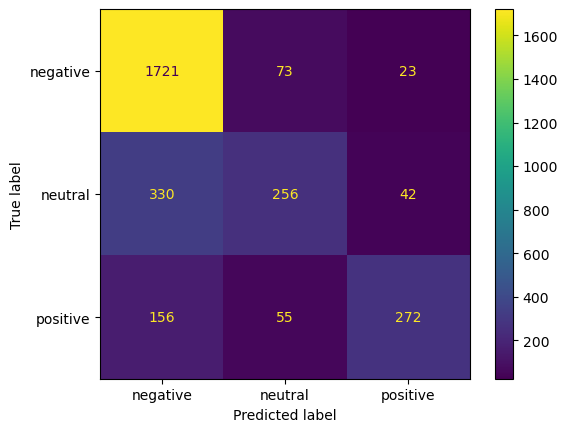

In [93]:
report(rbf_svc)

Получаем результаты в целом похожие на логистическую регрессию.

              precision    recall  f1-score   support

    negative       0.82      0.89      0.86      1817
     neutral       0.59      0.52      0.55       628
    positive       0.76      0.64      0.69       483

    accuracy                           0.77      2928
   macro avg       0.73      0.68      0.70      2928
weighted avg       0.76      0.77      0.77      2928



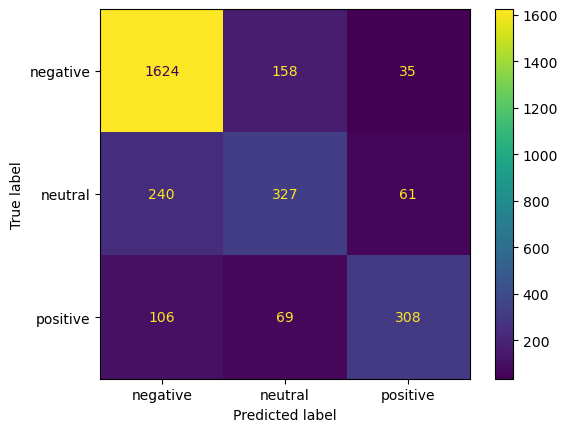

In [96]:
report(linear_svc)

В качестве следующего шага - можно попробовать настроить гиперпараметры для различных моделей.

## Создание пайплайна для применения к новым твитам
После того, как мы получили хорошо работающую модель, создадим пайплайн, который можно будет применять напрямую к входным текстовым данным (твитам).

In [110]:
from sklearn.pipeline import Pipeline

Мы собираем вместе все шаги обработки данных, которые нужно будет применять сразу к исходным данным.

In [113]:
pipe = Pipeline([('tfidf', TfidfVectorizer()), 
                 ('svc', LinearSVC())])

Обучим модель на ВСЕХ данных.

In [116]:
pipe.fit(X, y)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('svc', LinearSVC())])

In [118]:
pipe.predict(['good flight'])

array(['positive'], dtype=object)

In [120]:
pipe.predict(['ok flight'])

array(['neutral'], dtype=object)

In [122]:
pipe.predict(['bad flight'])

array(['negative'], dtype=object)